In [1]:
# magics: ensures that any changes to the modules loaded below will be re-loaded automatically
%load_ext autoreload
%autoreload 2

# load general packages
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')

# load general packages
import numpy as np

# load modules related to this exercise
from model_zucher import zurcher
from Solve_NFXP import solve_NFXP
import estimate_NFXP as estimate

#  Exercise 3: Demand function

#### 1. Find the equilibrium distirbution of mileage

In [18]:
# Setup
do_settings = {
    'n': 90
}

model = zurcher(**do_settings)
solver = solve_NFXP()

#Read the data
data = model.read_busdata(bustypes=[1,2,3,4])

samplesize = data.shape[0]
uncond_R_P = sum(data.d)/samplesize

# Estimate
nfxp_model, optim_res, pnames, theta_hat, Avar, converged=estimate.estimate(model, solver,data)



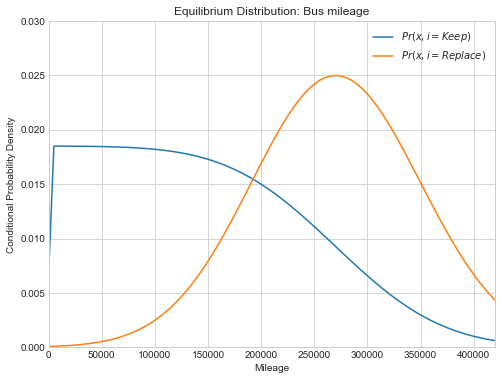

In [19]:
# Update the values with the estimated parameters
do_settings = {
    'n': 90,
    'RC': theta_hat[0],
    'c': theta_hat[1],
    'p': np.array(theta_hat[2:])
}

model_est = zurcher(**do_settings)
ev,pk = solver.poly(model_est.bellman, beta = model_est.beta, output=2)

# Find the probability functions
pp, pp_K, pp_R = model_est.eqb(pk)

fig = plt.figure(figsize=(8,6)) 
ax = fig.add_subplot(1,1,1)

ax.plot(model_est.grid*(model_est.max*1000)/model_est.n,pp_K/sum(pp_K))
ax.plot(model_est.grid*(model_est.max*1000)/model_est.n,pp_R/sum(pp_R))


ax.set_title(f'Equilibrium Distribution: Bus mileage')
ax.set_xlabel("Mileage")
ax.set_ylabel("Conditional Probability Density")
ax.set_xlim(0, 420000)
ax.set_ylim(0, 0.03)

plt.legend((f'$Pr(x, i=Keep)$',f'$Pr(x, i=Replace)$'))

plt.show()

#### 2. Find the scale of the cost function
a) How does the scale of the cost function relates to the estimate of RC and c?

b) What is the scale estimate? Hint: Use the stuctural estimates and tabel III in  Rust (1987), "Optimal Replacement of GMC Bus Engines: An Emperical Model of Harold Zurcher

In [20]:
RC = 8062
RC_scale = model_est.RC 
scale = RC/RC_scale

print(f'The scale for bustype 1-4 is: {scale:.2f}')

The scale for bustype 1-4 is: 810.01


#### 3. Find the implied Demand function

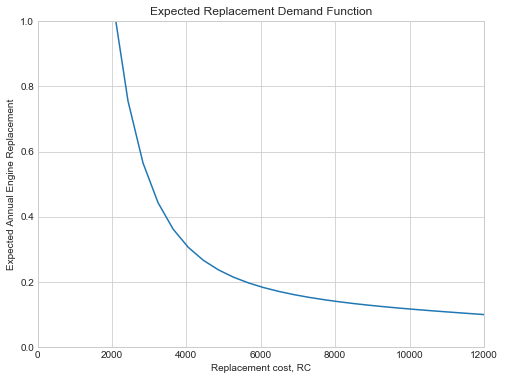

In [21]:
# Expected Demand, as a function of Replacement cost
import copy
mp0 = copy.copy(model_est.RC)
NRC = 59

RCgrid = np.linspace(1,30,NRC)
Demand = np.empty(NRC)

for i,val in enumerate(RCgrid):
    do_settings = {
        'n': 90,
        'RC': val,
        'c': theta_hat[1],
        'p': np.array(theta_hat[2:])
    }
    
    model = zurcher(**do_settings)
    _,pk = solver.poly(model.bellman, beta= model.beta, output=2)

    # Find the probability functions
    pp, pp_K, pp_R = model.eqb(pk)
    
    Demand[i] = 12*sum(pp_R)

fig = plt.figure(figsize=(8,6)) 
ax2 = fig.add_subplot(1,1,1)
ax2.plot(RCgrid*scale,Demand)
ax2.set_title(f'Expected Replacement Demand Function')
ax2.set_xlabel("Replacement cost, RC")
ax2.set_ylabel("Expected Annual Engine Replacement")
ax2.set_xlim(0,12000)
ax2.set_ylim(0,1)

plt.show()

#### 4. Try estimate the demand function for different values of $\beta$. Does the change in the demand function makes intuitively sense?

In [26]:
beta_vec = np.array([0, 0.9999])

Demand_beta = np.empty((NRC,2))
scale_beta = np.empty(2)


for j,beta in enumerate(beta_vec):
    # Setup
    do_settings = {
        'n': 90,
        'beta': beta
    }

    model = zurcher(**do_settings)
    solver = solve_NFXP()

    # Estimate
    _, _, _, theta_hat,_, _=estimate.estimate(model, solver,data)
    
    #do_settings = {
    #    'n': 90,
    #    'beta': beta,
    #    'RC': theta_hat[0],
    #    'c': theta_hat[1],
    #    'p': np.array(theta_hat[2:])
    #}

    #model_est = zurcher(**do_settings)
    #ev,pk = solver.poly(model_est.bellman, beta= model_est.beta, output=2)

    
    #scale_beta[j] = RC/copy.copy(model_est.RC)
    scale_beta[j] = RC/copy.copy(theta_hat[0])
    
    for i,val in enumerate(RCgrid):
        do_settings = {
            'n': 90,
            'beta': beta,
            'RC': val,
            'c': theta_hat[1],
            'p': np.array(theta_hat[2:])
        }
            
        model = zurcher(**do_settings)
        _,pk = solver.poly(model.bellman, beta=model.beta, output=2)

        # Find the probability functions
        pp, pp_K, pp_R = model.eqb(pk)
    

        Demand_beta[i,j] = 12*sum(pp_R)



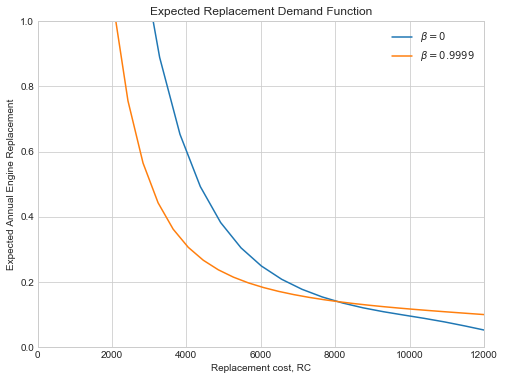

In [27]:
fig = plt.figure(figsize=(8,6)) 
ax2 = fig.add_subplot(1,1,1)
ax2.plot(RCgrid*scale_beta[0],Demand_beta[:,0])
ax2.plot(RCgrid*scale_beta[1],Demand_beta[:,1])
plt.legend((f'$\u03B2=0$',f'$\u03B2= 0.9999$'))
ax2.set_title(f'Expected Replacement Demand Function')
ax2.set_xlabel("Replacement cost, RC")
ax2.set_ylabel("Expected Annual Engine Replacement")
ax2.set_xlim(0,12000)
ax2.set_ylim(0,1)

plt.show()

#### 5. Now introduce five buses (M=5) instead of one bus, what is the combined demand?

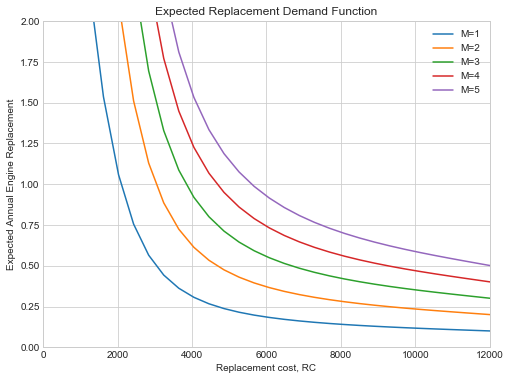

In [28]:
# Setup
fig = plt.figure(figsize=(8,6)) 
ax2 = fig.add_subplot(1,1,1)

ax2.plot(RCgrid*scale,Demand*1)
ax2.plot(RCgrid*scale,Demand*2)
ax2.plot(RCgrid*scale,Demand*3)
ax2.plot(RCgrid*scale,Demand*4)
ax2.plot(RCgrid*scale,Demand*5)
ax2.set_title(f'Expected Replacement Demand Function')
ax2.set_xlabel("Replacement cost, RC")
ax2.set_ylabel("Expected Annual Engine Replacement")
plt.legend((f'M=1',f'M=2', f'M=3', f'M=4', f'M=5'))
ax2.set_xlim(0,12000)
ax2.set_ylim(0,2)

plt.show()

#### 6. What are the advantage and disadvantage of using a structual model to estimate the demand?